# Lecture 5 -- Text Classification

## Outline

* one of the most common tasks in working with text is in classifying texts
* this can include things like classifying the topic of the text, the sentiment (is the text positive or negative), is the text toxic, etc.

* the general idea is that it's useful to categorize text. Instead of having a big blob of text, here is it's classification for which scientists, users, etc. can filter, subset, search, and utilize.

* for our use case, there are a couple of text classification models that we might be interested in
    * sentiment classification models are pretty universally useful -- in our case, potentially using them when paired with public comments to see how many comments are positive or negative in tone
    * identifying portions of the meeting by type -- i.e. "this general section of text is public comment, this general section is discussion on a bill", "a presentation", "voting", etc.
    * topic classification models specific to legislative topics -- i.e. general topic models might have too broad of a topic for our use cases, we might want to be able to classify discussion to finer grain discussion points

* this lecture will go over how to train a text classification model as applied to the "topic classification" task.

## Models and Evaluation

* we will not be covering how these models work, but rather their application on our dataset

* for a quick intro on logit models, watch these two videos: https://www.youtube.com/watch?v=7ArmBVF2dCs and https://www.youtube.com/watch?v=yIYKR4sgzI8
* For even more details, see: Dr. Mine Çetinkaya-Rundel's "Simple Linear Regression" Lecture: https://sta210-s22.github.io/website/slides/lec-2.html as an intro and then "Logistic Regression" lecture: https://sta210-s22.github.io/website/slides/lec-18.html#/topics, then multinomial logistic regression: https://sta210-s22.github.io/website/slides/lec-23.html#/title-slide

* it is also important to test your models performance

## An Example Classification Model

* Let's train two versions of the same classifier, one using the `TFIDFVectorizer` that we have already learned about to encode the text, and one using semantic embedding models to encode the text
* We will be using a dataset of short text snippets, three sentences in length, and manual annotations of the general topic or purpose of the text

In [1]:
import pandas as pd

# Load labeled text
labeled_text_snippets = pd.read_csv("text-snippets-labeled.csv")

# Show some examples for each label
for topic, group in labeled_text_snippets.groupby("topic"):
    print(topic)
    group_sample = group.sample(3)
    for sample in group_sample.text.values:
        print(f"\t{sample[:100]}")

admin
	So with that, I will be supporting this, and Madam Clerk, can you please call the roll? Councilmembe
	All right, not seeing any. Will the clerk please call the roll? Council Member Strauss?
	I'm Sarah Nelson, chair of the committee. Will the clerk please call the roll? Councilmember Sawant?
budget
	Okay. So you're saying, so you're making a direct correlation, but was, you know, the. The executive
	As I noted to provide an overall forecast for the rest of the revenue streams. I'll also note and li
	So in sort of final comments and next steps here, and Tom, you're welcome to keep that last slide up
housing
	Security issues, like locks and windows, and then fire safety, smoke, inoperable smoke detectors or 
	I want to thank the landlords of over 30,000 properties already registered with RRIO. Those properti
	I'm a renter living in District 2. I'm calling to urge the Seattle City Council to support Council M
labor
	We hear a lot, gig workers who are facing the impossible situation 

* hopefully you can already see that each piece of text seems to related to it's associated topic
* For another quick peek into the data we can print the counts of examples for each topic.

In [2]:
labeled_text_snippets.topic.value_counts()

labor        783
budget       635
public       385
police       313
housing      298
transport    234
admin        181
voting       164
parks        108
present       96
Name: topic, dtype: int64

### Data Splitting

* One of the most crucial parts of training any model is splitting the data into training and testing sets
* We will use the `train_test_split` function from `sklearn` to split our data into training and testing sets

In [3]:
from sklearn.model_selection import train_test_split

# Create splits
x_train, x_test, y_train, y_test = train_test_split(
    # "x": the inputs
    labeled_text_snippets,
    # "y": the outputs
    labeled_text_snippets.topic,
    # a percentage of how much data should be placed into a "test" set
    # 0.4 = 40%
    # common test sizes range from 0.1 to 0.4
    # depending on how much data you have available
    # and how much data you feel comfortable using as proof of your model's performance
    test_size=0.4,
    # stratify the data to ensure that the test set has the same
    # class distribution as the training set
    # i.e. if the training set has 10% class A and 90% class B
    # then the test set should also have 10% class A and 90% class B
    stratify=labeled_text_snippets.topic,
    # it's always useful to control randomness!
    random_state=42,
)

# Show the class distribution
print("TRAINING COUNTS")
print(y_train.value_counts())
print()
print()
print("TESTING COUNTS")
print(y_test.value_counts())

TRAINING COUNTS
labor        470
budget       381
public       231
police       188
housing      179
transport    140
admin        108
voting        98
parks         65
present       58
Name: topic, dtype: int64


TESTING COUNTS
labor        313
budget       254
public       154
police       125
housing      119
transport     94
admin         73
voting        66
parks         43
present       38
Name: topic, dtype: int64


### Training the TFIDF Vectorized Model

* now that we have our data split up into train and test splits,
    we will use the `TfidfVectorizer` to vectorize our text data
* in general, this is the same setup as we have used before but with three major changes:
    1. first we aren't going to stem each word, we will leave them as is for the sake of simplicity
    2. we are going to create unigrams (1 word tokens) and bigrams (2 word tokens)
    3. we are going to limit the number of features to 1024. this helps with two things, first, it helps with overfitting, where the model might learn that single words that appear rarely have an outsized impact on the model, and two, it reduces the size of the model which means faster to train and iterate on
* notably, the first step of this process is to call `fit_transform` on the `TfidfVectorizer` with ONLY the training data
* this is because we want to learn the vocabulary of the training data, and then use that vocabulary to vectorize the test data
* if we vectorized the test data in addition to the training data, we would be using information that we shouldn't have access to in the real world
* after we have vectorized the training data, we can then vectorize the test data using the `transform` method
* finally, we will use the training data (and the training labels) to train a logistic regression model

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import ConfusionMatrixDisplay, precision_recall_fscore_support
import matplotlib.pyplot as plt

# Create tfidf vectorized text
tfidf_vectorizer = TfidfVectorizer(
    strip_accents="unicode",
    stop_words="english",
    ngram_range=(1, 2),
    # Select top 1024 features instead of all
    # this drastically reduces the size of the model
    max_features=1024,
)
tfidf_x_train = tfidf_vectorizer.fit_transform(x_train.text)
tfidf_x_test = tfidf_vectorizer.transform(x_test.text)

# Train model
tfidf_clf = LogisticRegressionCV(random_state=42, max_iter=500)
tfidf_clf.fit(tfidf_x_train, y_train)

LogisticRegressionCV(max_iter=500, random_state=42)

### TFIDF Model Evaluation

* it seems like our model training completed without error but we still need to evaluate the model itself using the test data we set aside earlier
* we will use the `predict` method of the trained classifier to predict the labels for the test data
* and then we will get the precision, recall, and f1 scores for the model using the `precision_recall_fscore_support` function from `sklearn`


In [5]:
# Eval
y_pred = tfidf_clf.predict(tfidf_x_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

Precision: 0.934, Recall: 0.932, F1: 0.932


#### Evaluating the TFIDF Model per Label

* the overall model performance seems pretty great! we have a high f1 score and high precision and recall
* but note: we used `average="weighted"` which means it generates the scores _per label_ and then takes the weighted average of all of them together
* so while these seems great, we should always review the "confusion" matrix to see how the model performed per label

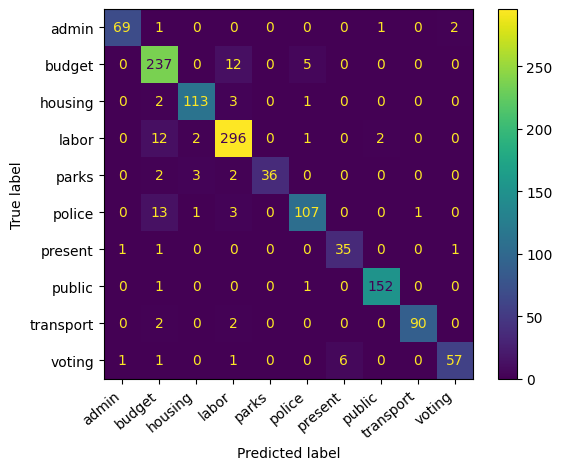

In [6]:
# Confusion per label
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=tfidf_clf.classes_)
_ = plt.xticks(rotation=40, ha="right")

* a confusion matrix can be intrepreted by looking at each row as the "true label" and each column as the "predicted label"
* in a perfect classification model, we would have a diagonal line of high values and everything else would be zero, meaning that every single example was classified into the correct label
* in our case, it seems like we are doing very well. as most of the data is on the diagonal but there are some cases that jump out at us
* for example, we have 12 examples that were predicted to be discussing something "budget" related but should their true label is actually that they are discussing "labor" related
* similarly, 13 examples were predicted to be discussing "budget" but were actually discussing "police"

#### Evaluating the TFIDF Model per Weight per Label

* one of the benefits of using a TFIDF logistic regression model is that we can look at the weights of each feature to see what words are having the most impact on the model
* we can do this by using a package called `eli5` ("explain like im 5") to look at the weights of each feature

In [7]:
from eli5.sklearn import explain_linear_regressor_weights

explain_linear_regressor_weights(
    # the classifier
    tfidf_clf,
    # the vectorizer that was used to transform the text
    vec=tfidf_vectorizer,
    # how many features to show in both the positive and negative directions
    # i.e. show the top 10 features that positively affect a classification decision in-favor of this label
    # and show the top 10 features that negatively affect a classification decision against this label
    top=(10, 10),
    # the "labels"
    target_names=tfidf_clf.classes_,
    # the feature names (in this case, the actual words)
    feature_names=tfidf_vectorizer.get_feature_names_out(),
)

2023-11-17 15:15:17.632002: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 15:15:17.673553: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-17 15:15:17.673585: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-17 15:15:17.674528: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-17 15:15:17.680582: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-11-17 15:15:17.680940: I tensorflow/core/platform/cpu_feature_guard.cc:1

Explanation(estimator='LogisticRegressionCV(max_iter=500, random_state=42)', description="\nFeatures with largest coefficients per target.\nCaveats:\n1. Be careful with features which are not\n   independent - weights don't show their importance.\n2. If scale of input features is different then scale of coefficients\n   will also be different, making direct comparison between coefficient values\n   incorrect.\n3. Depending on regularization, rare features sometimes may have high\n   coefficients; this doesn't mean they contribute much to the\n   classification result for most examples.\n", error=None, method='linear model', is_regression=True, targets=[TargetExplanation(target='admin', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='roll', weight=9.414837495620473, std=None, value=None), FeatureWeight(feature='clerk', weight=7.471782899253287, std=None, value=None), FeatureWeight(feature='committee', weight=4.2186946250473225, std=None, value=None), FeatureWeight(feature='clerk roll', weight=3.5417771640705675, std=None, value=None), FeatureWeight(feature='strauss', weight=2.7949445268916713, std=None, value=None), FeatureWeight(feature='passage', weight=2.7241051813842705, std=None, value=None), FeatureWeight(feature='sorry', weight=2.706927433213147, std=None, value=None), FeatureWeight(feature='council', weight=2.5683528902758543, std=None, value=None), FeatureWeight(feature='hearing', weight=2.4765587957823882, std=None, value=None), FeatureWeight(feature='roll passage', weight=2.4249011408496384, std=None, value=None)], neg=[FeatureWeight(feature='<BIAS>', weight=-1.2843715780251879, std=None, value=None), FeatureWeight(feature='member nelson', weight=-1.1662679104095304, std=None, value=None), FeatureWeight(feature='nelson', weight=-1.1636749373538355, std=None, value=None), FeatureWeight(feature='peterson', weight=-0.9110086122273242, std=None, value=None), FeatureWeight(feature='couple', weight=-0.8221585173528727, std=None, value=None), FeatureWeight(feature='public', weight=-0.8115949843768743, std=None, value=None), FeatureWeight(feature='present', weight=-0.7776765572276158, std=None, value=None), FeatureWeight(feature='aye', weight=-0.7686819956149669, std=None, value=None), FeatureWeight(feature='city', weight=-0.7217492610054884, std=None, value=None), FeatureWeight(feature='yes', weight=-0.7036916554626427, std=None, value=None)], pos_remaining=85, neg_remaining=920), proba=None, score=None, weighted_spans=None, heatmap=None), TargetExplanation(target='budget', feature_weights=FeatureWeights(pos=[FeatureWeight(feature='budget', weight=7.301901254293994, std=None, value=None), FeatureWeight(feature='forecast', weight=4.755416542065668, std=None, value=None), FeatureWeight(feature='budgeting', weight=4.477877221603187, std=None, value=None), FeatureWeight(feature='revenue', weight=4.280528153409132, std=None, value=None), FeatureWeight(feature='million', weight=4.065329059089581, std=None, value=None), FeatureWeight(feature='funds', weight=3.920739022899735, std=None, value=None), FeatureWeight(feature='cbo', weight=3.802029526496363, std=None, value=None), FeatureWeight(feature='revenues', weight=3.6287569889801845, std=None, value=None), FeatureWeight(feature='year', weight=3.5778301131096164, std=None, value=None), FeatureWeight(feature='economy', weight=3.461469419963445, std=None, value=None)], neg=[FeatureWeight(feature='amendment', weight=-3.4882334509181145, std=None, value=None), FeatureWeight(feature='concerns', weight=-2.885835377811535, std=None, value=None), FeatureWeight(feature='seattle', weight=-2.8569076235256565, std=None, value=None), FeatureWeight(feature='council', weight=-2.758363780082372, std=None, value=None), FeatureWeight(feature='trees', weight=-2.5692477134155047, std=None, value=None), FeatureWeight(feature='avenue', weight=-2.5120561428653496, std=None, value=None), FeatureWeight(feature='councilmember', weight=-2.4061343426373436, std=None, value=None), FeatureWeight(fea

* using `eli5` we can see the exact words (or ngrams) which are having the most impact on the model
* for example for the label "parks" we can see that the top two words are "tree" and "trees" which provide 10.816 and 9.731 points of weight respectively
* this makes sense, as we would expect that the word "tree" would be a good indicator that the text is discussing "parks"
* similarly, if we look at the weights for "housing" we can see that the most beneficial words for a piece of text to have are "landlords", "housing", "rental", "renters", "rent", etc.
* further we can see that the most detrimental words for a piece of text to be labeled as "housing" are "tree", "public", "councilmember", "budget", etc. this might make sense because some of these words (like "tree") aren't usually used in discussions about housing and other words like "budget" might not come up because housing discussions might be more focused on regulations and initiatives rather than funding

HOWEVER, there are some clear examples of why a `TfidfVectorized` model is good if you dataset is highly specific but bad if your dataset is more general.
* for example, we can see that for the label "present" (when roll call is happening and councilmembers are signing in) the most beneficial words are the councilmembers own names ("nelson", "lewis", "peterson", "mosqueda", etc.). This might be create if we only ever wanted to apply this model to data from the city of seattle council meetings but if we wanted to apply this model to other city council meetings, this existing model would not be very useful.
* similarly, even if we were only planning on applying this model to seattle city council meetings, but we wanted to apply the model over a large time period, the model might not work very well because the councilmembers change over time

* as discussed before, semantic embeddings tend to solve this problem as they are able to learn the conceptual meanings of the words rather than just counting their appearances, lets move on to training a model using semantic embeddings and compare the performance

### Training the Semantic Embedding Model

* we are largely going to reuse a lot of the same code from the TFIDF model as we are only changing the vectorizer (the thing that converts text to an array)
* in this case we are using the `SentenceTransformer` class from the `sentence_transformers` package to encode our text

Batches:   0%|          | 0/60 [00:00<?, ?it/s]

Batches:   0%|          | 0/40 [00:00<?, ?it/s]

Precision: 0.984, Recall: 0.984, F1: 0.984


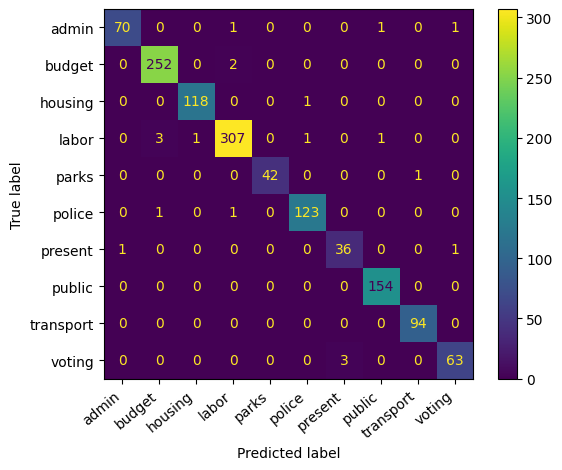

In [8]:
from sentence_transformers import SentenceTransformer

# Load the model
encoder = SentenceTransformer("BAAI/bge-base-en-v1.5")

# Create embedded text values
embedded_x_train = encoder.encode(x_train.text.values, show_progress_bar=True)
embedded_x_test = encoder.encode(x_test.text.values, show_progress_bar=True)

# Train model
trsfmr_clf = LogisticRegressionCV(random_state=42, max_iter=500)
trsfmr_clf.fit(embedded_x_train, y_train)

# Eval
y_pred = trsfmr_clf.predict(embedded_x_test)
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average="weighted")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1: {f1:.3f}")

# Confusion per label
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, labels=trsfmr_clf.classes_)
_ = plt.xticks(rotation=40, ha="right")

* from both the overall metrics and the confusion matrix, it seems like the semantic embedding model outperforms the TFIDF model
* specifically, from the confusion matrix it seems like we have almost a perfect diagonal line of correct predictions with some scattered incorrect predictions across the whole set.

## Packaging our Model

* it seems like our semantic embedding model out-performed our tfidf model, so lets save the trained model to a file so we can reuse it and reload it later

In [9]:
import skops.io as sklearn_io

# Save the model
sklearn_io.dump(trsfmr_clf, "semantic-classifier.skops")

* for example, here is how you would reload the model

In [10]:
new_model = sklearn_io.load("semantic-classifier.skops")
new_model

LogisticRegressionCV(max_iter=500, random_state=42)

## Applying our Model to Unseen Text

* To get some unseen text to the model, we can pull a sample of meetings from an entirely different council and create some text snippets to classify

In [11]:
from cdp_data import datasets, CDPInstances
from cdp_backend.pipeline.transcript_model import Transcript
import pandas as pd
from tqdm import tqdm

# pull meeting sessions from king county council
sessions = datasets.get_session_dataset(
    CDPInstances.KingCounty,
    start_datetime="2022-03-15",
    end_datetime="2022-03-21",
    store_transcript=True,
)

# Go from 0 to end with 3 sentence steps
# iterate over all sessions, and for each session read the transcript
# then for each triple of sentences in the transcript form a text snippet
text_snippets = []
step_size = 3
for __, session in tqdm(sessions.iterrows(), desc="sessions", total=len(sessions)):
    # Read transcript
    with open(session.transcript_path) as open_f:
        transcript = Transcript.from_json(open_f.read())

    for sent_index in range(0, len(transcript.sentences), step_size):
        sentence_block = transcript.sentences[sent_index: sent_index + step_size]
        text_snippets.append({
            "text": " ".join([s.text for s in sentence_block]),
            "session_id": session["id"],
        })

# Store to dataframe and get embeddings
text_snippets = pd.DataFrame(text_snippets)
text_snippets.sample(3)

Fetching each model attached to event_ref:   0%|          | 0/5 [00:00<?, ?it/s]

Fetching transcripts:   0%|          | 0/5 [00:00<?, ?it/s]

sessions: 100%|██████████| 5/5 [00:04<00:00,  1.09it/s]


,text,session_id
1209,We been able to D intensify shelters for peopl...,6e74f7b07550
239,"Would you be willing to put ordinance, 2022, 0...",6ef1d637f401
814,What are the funding opportunity? They could t...,44057c62713a


* first we need to get semantic encodings for each of the text snippets
* then lets use the loaded model (just for demonstration that the newly loaded model acts the same as the original) and predict a label for each text snippet

In [12]:
import numpy as np

# Create a new encoder (not needed if you already have one loaded)
encoder = SentenceTransformer("BAAI/bge-base-en-v1.5")

# Created embedded values for each piece of text
text_snippets["embedding"] = list(encoder.encode(text_snippets.text.values, show_progress_bar=True))

# Classify using the embeddings
text_snippets["topic"] = list(new_model.predict(np.stack(text_snippets.embedding.values)))
text_snippets.sample(3)

Batches:   0%|          | 0/41 [00:00<?, ?it/s]

,text,session_id,embedding,topic
105,"Okay, here, Lou welcome. And the floor is your...",6ef1d637f401,"[0.016617041, -0.016158227, 0.019799111, -0.03...",public
1199,We've put committees together and we use these...,6e74f7b07550,"[0.034155205, -0.0217096, 0.00835186, 0.003042...",budget
1292,Other discussion. On anything that is poor t...,6e74f7b07550,"[0.013785125, -0.01614475, 0.0105166305, 0.002...",labor


In [13]:
# Take groups of text snippets and display examples of text
for topic, group in text_snippets.groupby("topic"):
    print(topic)
    group_sample = group.sample(3)
    for sample in group_sample.text.values:
        print(f"\t{sample[:100]}")

admin
	Hi, mr. Chair. The vote is seven eyes and council members are highly excused.
	Welcome to the mic 16 2022 remote meeting of the committee of the whole. I am Jean Caldwell's and I'
	For non elected, members of the Board of Health. And then, to take up that bring those of nominees b
budget
	I believe it was stated that they were 20 2000 5 6 etcetera. It is 2022 in each of those legislative
	This is a program we've had around for a while. And in this case, a permission doubled, the amount o
	And what Felicia and I talked about daily is, are we aligned granularly? Right? Like, so like, we ha
housing
	Whether it's the federal government, whether it's County government, the flood District, very import
	This document serves at the as the update to the 2005 plan and in 1999, the Puget. Sound should exam
	I'm Susie Levy board, administrator with public health, Seattle, King County. I'm going to take a fe
labor
	 You of the recruitment and selection process. I would mention that the board

TODO: possible exercise, try and debug what is going wrong with the predictions, specifically point them to sklearn predictproba and maybe doubtlab (https://github.com/koaning/doubtlab)